In [47]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

torch.set_default_tensor_type(torch.FloatTensor)

In [48]:
#########获取数据###########
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
#print(train_set.shape)  80 features 1 label
#print(test_set.shape)
features = pd.concat((train_set.iloc[:,1:-1],test_set.iloc[:,1:]))

In [49]:
#########预处理数据###########
numeric_features = features.dtypes[features.dtypes!='object'].index
#normalization
features[numeric_features] = features[numeric_features].apply(
    lambda x : (x - x.mean()) / (x.std())
)
features = features.fillna(0)
#离散数值转化成指示特征
features = pd.get_dummies(features,dummy_na=True)
#print(features.shape)
#数据转化为NumPy格式
n_train = train_set.shape[0]
train_set_features = torch.tensor(features[:n_train].values,dtype=torch.float)
test_set_features = torch.tensor(features[n_train:].values,dtype=torch.float)
train_set_labels = torch.tensor(train_set.SalePrice.values,dtype=torch.float).view(-1,1)

In [50]:
#########训练模型###########
loss = nn.MSELoss()
def get_net(feature_num):
    net = nn.Linear(feature_num,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net
#对数均方根误差
def RMSE(net,features,labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features),torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(),labels.log()).mean())
    return rmse.item()

def train(net,train_features,train_labels,test_features,test_labels,
          num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls = [],[]
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    #Adam优化
    optimizer = torch.optim.Adam(params=net.parameters(),
                                 lr=learning_rate,weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for x,y in train_iter:
            #print(x.shape)
            #print(y.shape)
            l = loss(net(x.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(RMSE(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(RMSE(net,test_features,test_labels))
    return  train_ls,test_ls

In [51]:
#########K折交叉验证###########
def get_k_fold_data(k,i,x,y):
    #return the i th fold data
    assert k>1
    fold_size = x.shape[0] // k
    x_train,y_train = None,None
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size)
        x_part,y_part = x[idx,:],y[idx]
        if j == i:
            x_valid,y_valid = x_part,y_part
        elif x_train is None:
            x_train,y_train = x_part,y_part
        else:
            x_train = torch.cat((x_train, x_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return x_train,y_train,x_valid,y_valid

def k_fold(k, X_train, y_train, num_epochs,
            learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs,learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls,
                         'epochs', 'rmse',range(1, num_epochs + 1),
                         valid_ls,['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i,train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.239788, valid rmse 0.220820
fold 1, train rmse 0.229667, valid rmse 0.270692
fold 2, train rmse 0.232149, valid rmse 0.237945
fold 3, train rmse 0.237958, valid rmse 0.218595
fold 4, train rmse 0.230165, valid rmse 0.259033
5-fold validation: avg train rmse 0.233945, avg valid rmse 0.241417


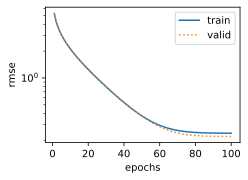

In [52]:
#########模型选择###########
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_set_features, train_set_labels,
                          num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' %(k, train_l, valid_l))

In [53]:
#预测
def train_and_pred(train_features,test_features,train_labels,test_data,
                   num_epochs,lr,weight_decay,batch_size):
    net = get_net(train_features.shape[1])
    train_ls,_ = train(net,train_features,train_labels,None,None,
                       num_epochs,lr,weight_decay,batch_size)
    d2l.semilogy(range(1,num_epochs+1),train_ls,'epoch','RMSE')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'],
                            test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

torch.Size([1460, 354])
torch.Size([1460, 1])
train rmse 0.229741


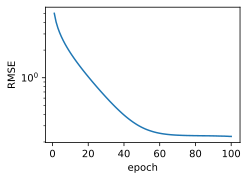

In [54]:
print(train_set_features.shape)
print(train_set_labels.shape)
train_and_pred(train_set_features, test_set_features, train_set_labels,
test_set, num_epochs, lr, weight_decay, batch_size)